# 1. Business Problem
## 1.1 Problem Context

Our client is a large Real Estate Investment Trust (REIT).
* They invest in houses, apartments, and condos(complex of buildings) within a small county in New York state.
* As part of their business, they try to predict the fair transaction price of a property before it's sold.
* They do so to calibrate their internal pricing models and keep a pulse on the market.

## 1.2 Problem Statement
The REIT has hired us to find a data-driven approach to valuing properties.
* They currently have an untapped dataset of transaction prices for previous properties on the market.
* The data was collected in 2016.
* Our task is to build a real-estate pricing model using that dataset.
* If we can build a model to predict transaction prices with an average error of under US Dollars 70,000, then our client will be very satisfied with the our resultant model.

## 1.3 Business Objectives and Constraints
* Deliverable: Trained model file
* Win condition: Avg. prediction error < \$70,000
* Model Interpretability will be useful
* No latency requirement

# 2. Machine Learning Problem
## 2.1 Data Overview

For this project:
1. The dataset has 1883 observations in the county where the REIT operates.
2. Each observation is for the transaction of one property only.
3. Each transaction was between \$200,000 and \$800,000.

#### Target Variable
* 'tx_price' - Transaction price in USD

#### Features of the data:

Public records:
* 'tx_year' - Year the transaction took place
* 'property_tax' - Monthly property tax
* 'insurance' - Cost of monthly homeowner's insurance

Property characteristics:
* 'beds' - Number of bedrooms
* 'baths' - Number of bathrooms
* 'sqft' - Total floor area in squared feet
* 'lot_size' - Total outside area in squared feet
* 'year_built' - Year property was built
* 'active_life' - Number of gyms, yoga studios, and sports venues within 1 mile
* 'basement' - Does the property have a basement?
* 'exterior_walls' - The material used for constructing walls of the house
* 'roof' - The material used for constructing the roof

Location convenience scores:
* 'restaurants' - Number of restaurants within 1 mile
* 'groceries' - Number of grocery stores within 1 mile
* 'nightlife' - Number of nightlife venues within 1 mile
* 'cafes' - Number of cafes within 1 mile
* 'shopping' - Number of stores within 1 mile
* 'arts_entertainment' - Number of arts and entertainment venues within 1 mile
* 'beauty_spas' - Number of beauty and spa locations within 1 mile
* 'active_life' - Number of gyms, yoga studios, and sports venues within 1 mile

Neighborhood demographics:
* 'median_age' - Median age of the neighborhood
* 'married' - Percent of neighborhood who are married
* 'college_grad' - Percent of neighborhood who graduated college

Schools:
* 'num_schools' - Number of public schools within district
* 'median_school' - Median score of the public schools within district, on the range 1 - 10

## 2.2 Mapping business problem to ML problem
### 2.2.1 Type of Machine Learning Problem
It is a regression problem, where given the above set of features, we need to predict the transaction price of the house.

### 2.2.2 Performance Metric (KPI)
**Since it is a regression problem, we will use the following regression metrics:**
#### 2.2.2.1 Root Mean Squared Error (RMSE)

![title](Images/rmse.gif)

#### 2.2.2.2 R-squared
![title](Images/r_squared.png)

Just remember the value of R suared must be at least greater than 0 and 1 in the best case

#### 2.2.2.3 Mean Absolute Error (MAE):
![title](Images/mae.png)

* Remember, our win-condition for this project is predicting within \$70,000 of true transaction prices, on average.
* Mean absolute error (or MAE) is the average absolute difference between predicted and actual values for our target variable. That exactly aligns with the terms of our win condition!
* So we're aiming to get MAE below 70,000

## Train-Test Splits
**80-20**

# Exploratory data analysis

#### Import the libraries

In [7]:
# for numerical computing
import numpy as np

# for dataframes
import pandas as pd

# for easier visualization
import seaborn as sns

# for visualization and to display plots
from matplotlib import pyplot as plt
%matplotlib inline

# import color maps
from matplotlib.colors import ListedColormap

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from math import sqrt

# to split train and test set
from sklearn.model_selection import train_test_split

# to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Ridge  # Linear Regression + L2 regularization
from sklearn.linear_model import Lasso  # Linear Regression + L1 regularization
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

#import xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor
from xgboost import plot_importance  # to plot feature importance

# to save the final model on disk
from sklearn.externals import joblib

In [3]:
np.set_printoptions(precision=2, suppress=True) #for printing floating point numbers upto  precision 2

Load real estate data from CSV

In [96]:
df = pd.read_csv('Files/real_estate_data.csv')

Display the dimensions of the dataset.

In [97]:
df.shape

(1883, 26)

Columns of the dataset

In [98]:
df.columns

Index(['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size',
       'property_type', 'exterior_walls', 'roof', 'basement', 'restaurants',
       'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment',
       'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad',
       'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year'],
      dtype='object')

Display the first 5 rows to see example observations.

In [99]:
pd.set_option('display.max_columns', 20) ## display max 20 columns
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,...,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


Some feaures are numeric and some are categorical<br>
Filtering the categorical features:

In [100]:
df.dtypes[df.dtypes=='object']

property_type     object
exterior_walls    object
roof              object
dtype: object

## Distributions of numeric features
One of the most enlightening data exploration tasks is plotting the distributions of your features.

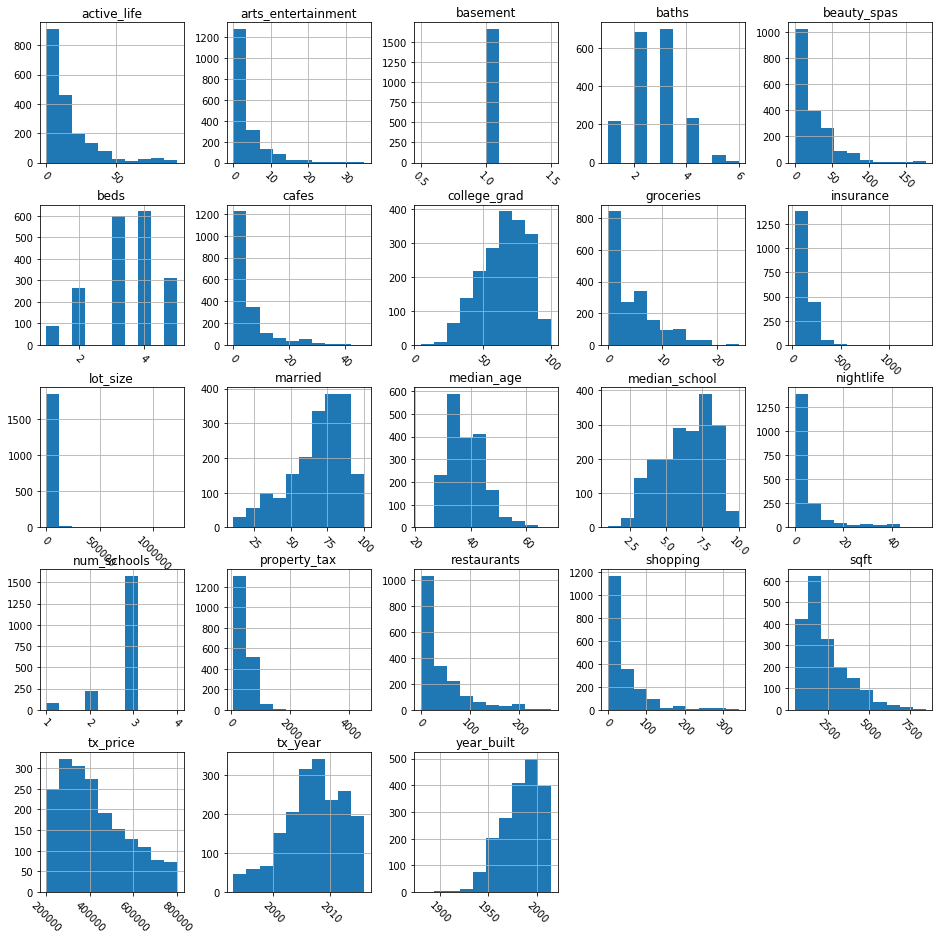

In [101]:
# Plot histogram grid
df.hist(figsize=(16,16), xrot=-45) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()

**Observations:**
We can make out quite a few observations:

For example, consider the histogram for num_schools:
* More than 1500 houses have 3 schools with a mile

Consider the histogram for sqft:
* More than 400 houses have area within 2000 sqft
* Very few houses have area more than 5000 sqft

Consider the histogram for beds:
* Over 600 houses have 4 bedrooms, and similar number of houses have 3 bedrooms.
* Less than 100 houses have one bedroom and so on.

Also, look at the plot for the 'year_built' feature:
* The last bin in the histogram represents the range 2010-2020.
* Since this dataset was pulled in 2016, we should not have properties built in 2019.
* A property built after 2016 would be a measurement error.
* However, because of the 10-year bins, it's hard to tell if there's a measurement error just from the plot above.

Display summary statistics for the numerical features.

In [9]:
df.describe()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1.883000e+03,1657.0,1883.000000,1883.000000,1883.000000,...,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,422839.807754,3.420605,2.579926,2329.398832,1982.963887,1.339262e+04,1.0,40.210303,4.505045,5.074881,...,23.416888,15.835369,38.601168,69.091875,65.085502,466.777483,140.454063,6.502921,2.793415,2007.111524
std,151462.593276,1.068554,0.945576,1336.991858,20.295945,4.494930e+04,0.0,46.867012,4.491029,8.464668,...,25.776916,17.667717,6.634110,19.659767,16.953165,231.656645,72.929765,1.996109,0.505358,5.196898
min,200000.000000,1.000000,1.000000,500.000000,1880.000000,0.000000e+00,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,22.000000,11.000000,5.000000,88.000000,30.000000,1.000000,1.000000,1993.000000
25%,300000.000000,3.000000,2.000000,1345.000000,1970.000000,1.542000e+03,1.0,7.000000,1.000000,0.000000,...,4.000000,4.000000,33.000000,58.000000,54.000000,320.000000,94.000000,5.000000,3.000000,2004.000000
50%,392000.000000,3.000000,3.000000,1907.000000,1986.000000,6.098000e+03,1.0,23.000000,3.000000,2.000000,...,15.000000,10.000000,38.000000,73.000000,66.000000,426.000000,125.000000,7.000000,3.000000,2007.000000
75%,525000.000000,4.000000,3.000000,3005.000000,2000.000000,1.176100e+04,1.0,58.000000,7.000000,6.000000,...,35.000000,21.000000,43.000000,84.000000,78.000000,569.000000,169.000000,8.000000,3.000000,2011.000000
max,800000.000000,5.000000,6.000000,8450.000000,2015.000000,1.220551e+06,1.0,266.000000,24.000000,54.000000,...,177.000000,94.000000,69.000000,100.000000,100.000000,4508.000000,1374.000000,10.000000,4.000000,2016.000000


**Obeservation:**
* Look at the 'year_built' column, we can see that its max value is 2015.
* The 'basement' feature has some missing values, also its standard deviation is 0.0, while its min and max are both 1.0. Maybe this is a feature that should be binary consisting values 0 and 1.

## Distributions of categorical features
Display summary statistics for categorical features.

In [10]:
df.describe(include=['object'])

,property_type,exterior_walls,roof
count,1883,1660,1529
unique,2,16,16
top,Single-Family,Brick,Composition Shingle
freq,1080,687,1179


**Observation:**
* 'exterior_walls' and 'roof' have missing values
* There are 16 unique classes for 'exterior_walls' and 'roof'
* The most frequent element for exterior_walls is 'Brick'and it has come 687 times.

### Bar plots for categorical Features

Plot bar plot for the 'exterior_walls' feature.

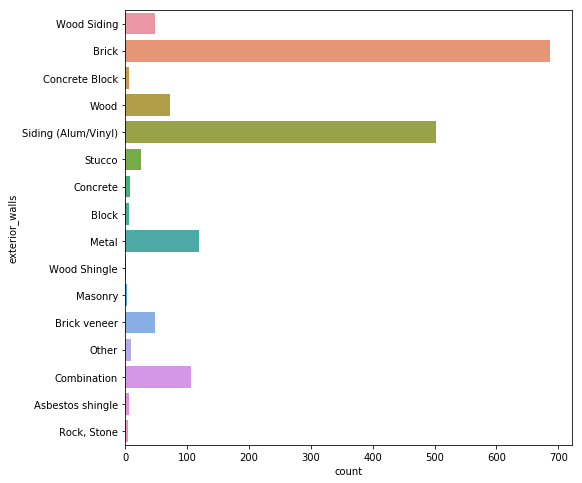

In [11]:
plt.figure(figsize=(8,8))
sns.countplot(y='exterior_walls', data=df)

**Observations:**
Take a look at the frequencies of the classes.

Several classes are quite prevalent in the dataset. They have long bars. Those include:
* 'Brick' shows count of 687 as we get in features and is most frequent
* 'Siding (Alum/Vinyl)'
* 'Metal'
* 'Combination'

Some classes have really short bars. For example:
* 'Concrete Block'
* 'Concrete'
* 'Block'
* 'Wood Shingle'
* others
* These don't have many observations, and they are called sparse classes.

Similarly Plot bar plot for the 'roof' feature.

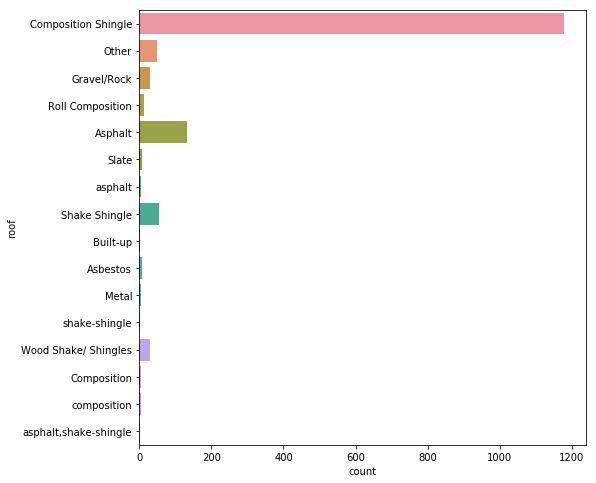

In [12]:
plt.figure(figsize=(8,8))
sns.countplot(y='roof', data=df)

**Observations:**

* The class which has a lasrgest count is Composition Shingle

Following are the sparse classes having very small bars/observations:
* 'Metal'
* 'shake-shingle'
* 'composition'

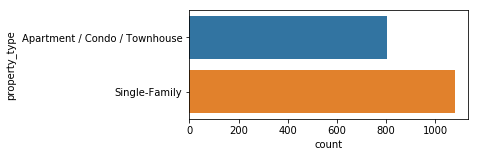

In [13]:
plt.figure(figsize=(5,2))
sns.countplot(y='property_type', data=df)

** Observation **:
* Property_type having single family has maximum count greater than 1000
* There is no sparse class in property_type

## Sparse Classes
Sparse classes are classes in categorical features that have a very small number of observations.

They tend to be problematic when we get to building models.
* In the best case, they don't influence the model much.
* In the worst case, they can cause the model to be overfit.

Let's make a mental note to combine or reassign some of these classes later.

From the above bar plots:

**Observations:** In both 'exterior_walls' and 'roof' as well we have many sparse classes

##  Segmentations
Segmentations are powerful ways to cut the data to observe the relationship between categorical features and numeric features.

Segmenting the target variable by key categorical features.

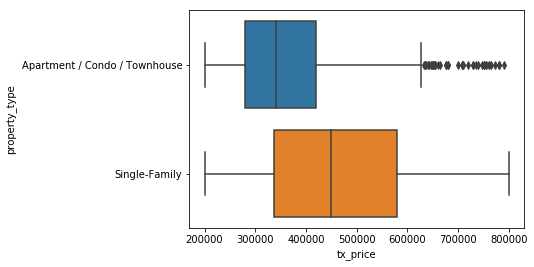

In [14]:
sns.boxplot(y='property_type', x='tx_price', data=df)

**Observation:** In general, it looks like single family homes are more expensive.

Let's compare the two property types across other features as well

In [15]:
df.groupby('property_type').mean()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
property_type,,,,,,,,,,,,,,,,,,,,,
Apartment / Condo / Townhouse,366614.034869,2.601494,2.200498,1513.727273,1988.936488,3944.239103,1.0,58.418431,5.919054,7.855542,...,32.087173,22.410959,37.199253,57.534247,66.372354,346.261519,105.652553,6.382316,2.831880,2007.941469
Single-Family,464644.711111,4.029630,2.862037,2935.865741,1978.523148,20417.666667,1.0,26.672222,3.453704,3.007407,...,16.970370,10.946296,39.643519,77.685185,64.128704,556.383333,166.329630,6.592593,2.764815,2006.494444


** Observations **:
* Property having single-family is larger in sqft area.It also has more bedrooms than other property-type.
* Apartment/townhouse has larger lots than the property having single-family.
* Apartmenr/condo/Townhouse type of property is in areas with more restaurants,nightlife options,more grocery stores,shopping stores,active_life(gym,sports,yoga studios)
* Property_type such as apartments,Condo,Townhouse is more crowded and so have more fascilities but smaller in sqft area so have lesser price whereas property-type having single-family are generally large in size and has lesser fascilities as less crowded. 

Segment 'sqft' by 'property_type' and plot the boxplots.

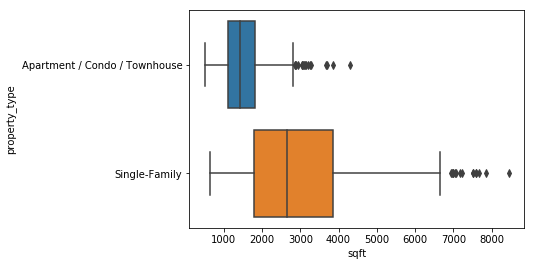

In [16]:
sns.boxplot(y='property_type', x='sqft', data=df)

After producing the plot, consider these questions:
* property-type single family is larger, on average.
* Property-type single family has greater variance in sizes.
* Sqft area of Apartment type property lies between 1000 to 2000 and have no much variation.It always has area lesser than single-family houses

Segment by property_type and display the means and standard deviations within each class

In [17]:
df.groupby('property_type').agg([np.mean, np.std])

tx_price                     beds  \
                                        mean            std      mean   
property_type                                                           
Apartment / Condo / Townhouse  366614.034869  121784.490486  2.601494   
Single-Family                  464644.711111  157758.739013  4.029630   

                                            baths                   sqft  \
                                    std      mean       std         mean   
property_type                                                              
Apartment / Condo / Townhouse  0.810220  2.200498  0.815009  1513.727273   
Single-Family                  0.795639  2.862037  0.937551  2935.865741   

                                             year_built               ...     \
                                       std         mean        std    ...      
property_type                                                         ...      
Apartment / Condo / Townhouse   556.286650  1988.936488  15.513640    ...      
Single-Family                  1422.871169  1978.523148  22.210582    ...      

                              property_tax               insurance             \
                                      mean         std        mean        std   
property_type                                                                   
Apartment / Condo / Townhouse   346.261519  142.292282  105.652553  47.118015   
Single-Family                   556.383333  244.351559  166.329630  77.816022   

                              median_school           num_schools            \
                                       mean       std        mean       std   
property_type                                                                 
Apartment / Condo / Townhouse      6.382316  1.941998    2.831880  0.455370   
Single-Family                      6.592593  2.031663    2.764815  0.537959   

                                   tx_year            
                                      mean       std  
property_type                                         
Apartment / Condo / Townhouse  2007.941469  4.099487  
Single-Family                  2006.494444  5.807059  

[2 rows x 46 columns]

## Correlations
* Finally, let's take a look at the relationships between numeric features and other numeric features.
* ***Correlation*** is a value between -1 and 1 that represents how closely values for two separate features move in unison.
* Positive correlation means that as one feature increases, the other increases; eg. a child's age and her height.
* Negative correlation means that as one feature increases, the other decreases; eg. hours spent studying and number of parties attended.
* Correlations near -1 or 1 indicate a strong relationship.
* Those closer to 0 indicate a weak relationship.
* 0 indicates no relationship.

In [18]:
df.corr()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
tx_price,1.000000,0.384046,0.389375,0.469573,0.033138,0.130558,NaN,-0.038027,-0.094314,0.009361,...,-0.054349,-0.001165,0.126335,0.200494,0.268577,0.535148,0.532947,0.175762,-0.014380,0.108782
beds,0.384046,1.000000,0.644572,0.691039,-0.011844,0.164399,NaN,-0.495834,-0.421412,-0.440844,...,-0.419832,-0.486957,0.133711,0.643240,-0.082354,0.547643,0.485776,0.137309,-0.124359,-0.174081
baths,0.389375,0.644572,1.000000,0.682060,0.206141,0.132976,NaN,-0.350210,-0.340024,-0.306686,...,-0.282008,-0.329736,0.095844,0.442225,0.016097,0.525776,0.475430,0.163365,-0.088299,-0.132110
sqft,0.469573,0.691039,0.682060,1.000000,0.254589,0.246016,NaN,-0.353759,-0.371167,-0.281540,...,-0.310465,-0.332663,0.109811,0.480167,0.065343,0.660264,0.594049,0.220669,-0.102032,-0.236190
year_built,0.033138,-0.011844,0.206141,0.254589,1.000000,0.000068,NaN,-0.106948,-0.222443,-0.080006,...,-0.163670,-0.134919,-0.237152,0.038208,-0.014204,-0.046504,-0.109521,0.155835,-0.188106,-0.043301
lot_size,0.130558,0.164399,0.132976,0.246016,0.000068,1.000000,NaN,-0.113887,-0.118574,-0.072224,...,-0.121075,-0.092668,0.099140,0.122028,-0.030725,0.165800,0.146579,0.096551,-0.031535,-0.048207
basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurants,-0.038027,-0.495834,-0.350210,-0.353759,-0.106948,-0.113887,NaN,1.000000,0.701462,0.926675,...,0.867829,0.881799,-0.063816,-0.615584,0.214260,-0.100821,-0.019925,-0.068425,0.251171,0.044739
groceries,-0.094314,-0.421412,-0.340024,-0.371167,-0.222443,-0.118574,NaN,0.701462,1.000000,0.565003,...,0.626850,0.574532,-0.022377,-0.508793,-0.006025,-0.159506,-0.093974,-0.354553,0.272856,0.115674
nightlife,0.009361,-0.440844,-0.306686,-0.281540,-0.080006,-0.072224,NaN,0.926675,0.565003,1.000000,...,0.777461,0.858836,-0.028611,-0.568811,0.253717,-0.054386,0.024551,-0.036948,0.196399,0.027495


#### A lot of numbers make things difficult to read. So let's visualize this.
But first, it's important to notice that the correlations for 'basement' all show as NaN. This is expected because right now that feature doesn't vary at all (its standard deviation is 0), as we saw all the way back in step 2. We'll fix this later.

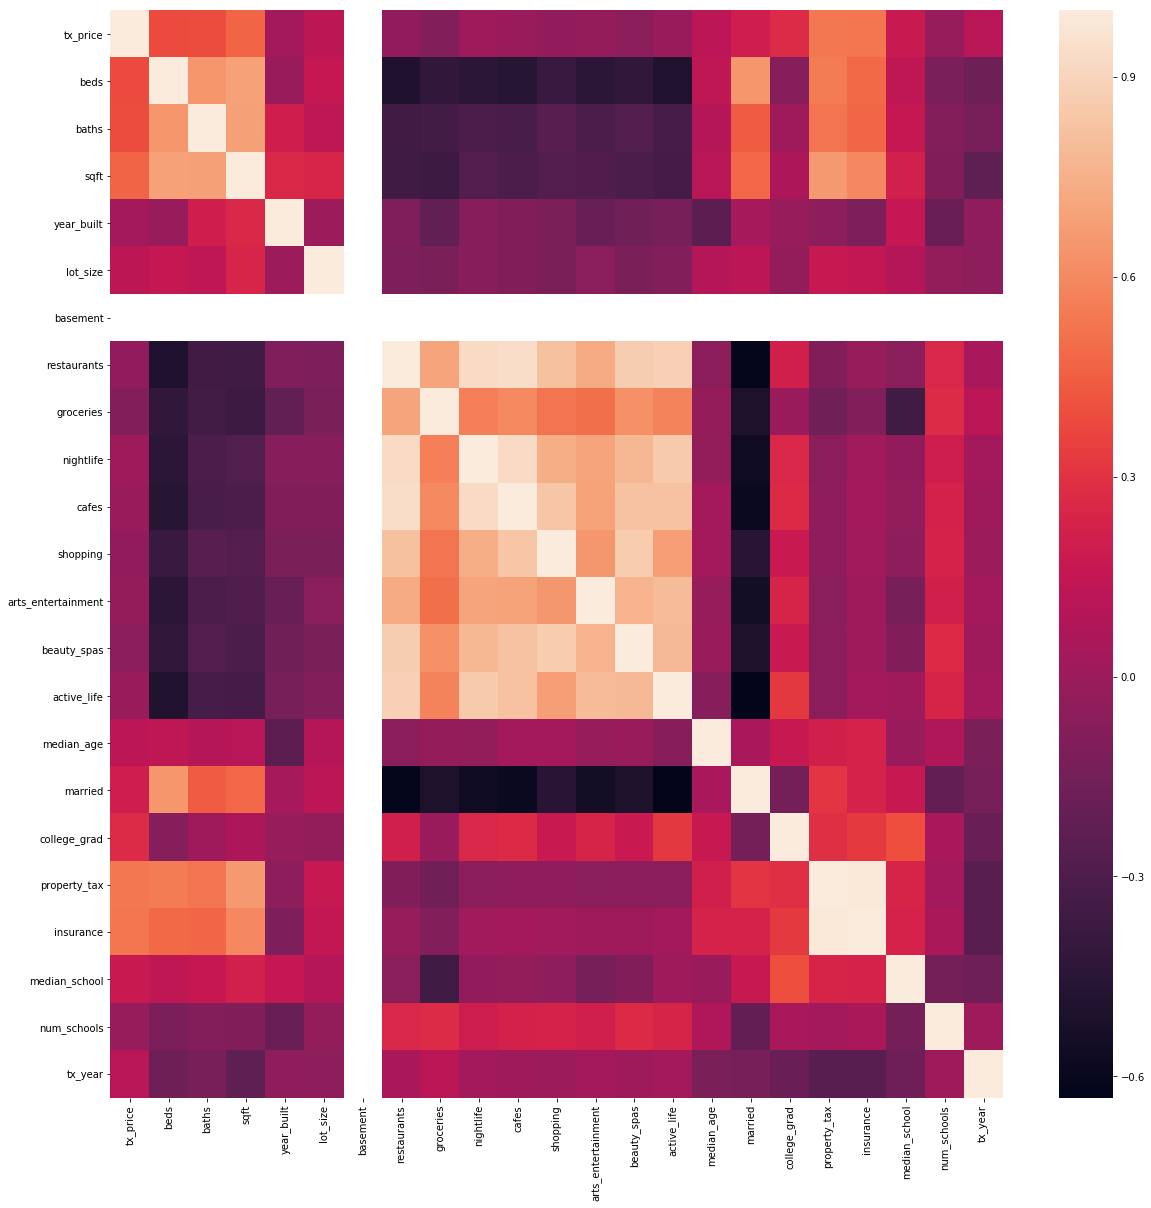

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

**What to look for?**
* The colorbar on the right explains the meaning of the heatmap - Dark colors indicate **strong negative correlations** and light colors indicate **strong positive correlations**.
* Perhaps the most helpful way to interpret this correlation heatmap is to first find features that are correlated with our target variable by scanning the first column.
* In this case, it doesn't look like many features are strongly correlated with the target variable.

* Example: there is a strong negative correlation between beds and restaurants, or gloceries and median_schools.
* There is a weak positive correlation between 'tx_price' and 'property_tax'.

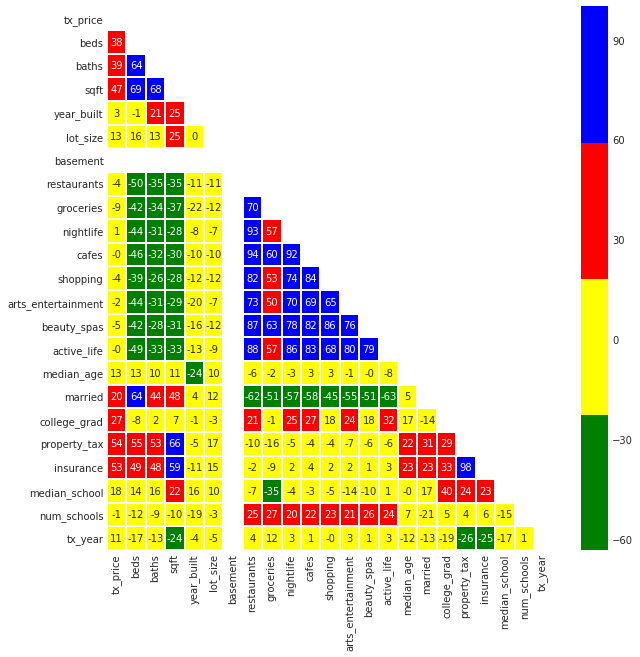

In [20]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['green', 'yellow', 'red','blue']))

# Data Cleaning

##  Dropping the duplicates (De-duplication)


In [102]:
df = df.drop_duplicates()
print( df.shape )

(1883, 26)


It looks like we didn't have any duplicates in our original dataset. Even so, it's a good idea to check this as an easy first step for cleaning your dataset.

## Fix structural errors
* The basement feature has some nan values, to handle them:

In [103]:
df.basement.unique()

array([ nan,   1.])

* Even though NaN represents "missing" values, those are actually meant to indicate properties without basements.
* Fill missing 'basement' values with the value 0 to turn 'basement' into a true indicator variable.

In [104]:
df.basement.fillna(0, inplace=True)

In [105]:
df.basement.unique()

array([ 0.,  1.])

##  Typos and capitalization

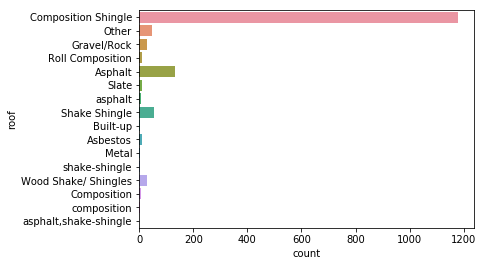

In [106]:
# Class distributions for 'roof'
sns.countplot(y='roof', data=df)

Using this plot, we can easily catch typos and inconsistent capitalization. For example:
* 'composition' should be 'Composition'
* 'asphalt' should be 'Asphalt'
* 'shake-shingle' should be 'Shake Shingle'
* 'asphalt,shake-shingle' could probably just be 'Shake Shingle'

In [107]:
df.roof.replace('composition', 'Composition', inplace=True)
df.roof.replace('asphalt', 'Asphalt', inplace=True)
df.roof.replace(['shake-shingle', 'asphalt,shake-shingle'], 'Shake Shingle', inplace=True)

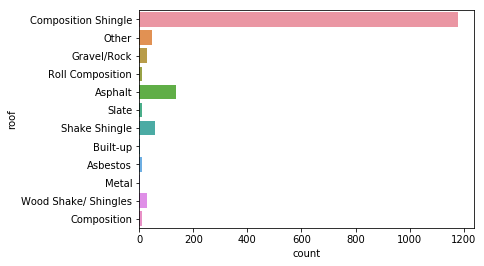

In [108]:
# Class distribution for 'roof' after the modifications
sns.countplot(y='roof', data=df)

##  Mislabeled classes
Finally, we'll check for classes that are labeled as separate classes when they should really be the same.
* e.g. If 'N/A' and 'Not Applicable' appear as two separate classes, we should combine them.
* let's plot the class distributions for 'exterior_walls':

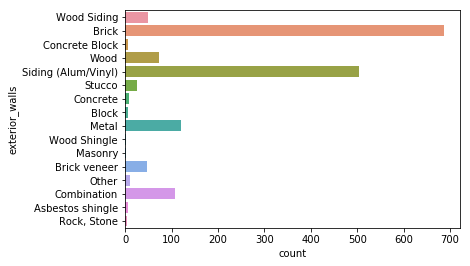

In [109]:
sns.countplot(y='exterior_walls', data=df)

Using that chart, we can easily catch mislabeled classes. For example
* 'Rock, Stone' should be 'Masonry'
* 'Concrete' and 'Block' should both just be 'Concrete Block'

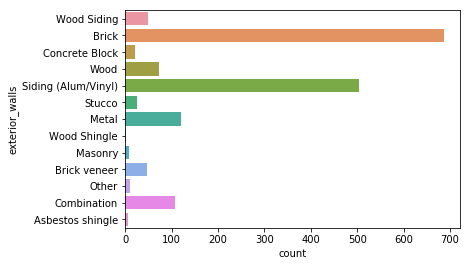

In [110]:
df.exterior_walls.replace(['Rock, Stone'], 'Masonry', inplace=True)
df.exterior_walls.replace(['Concrete', 'Block'], 'Concrete Block', inplace=True)
sns.countplot(y='exterior_walls', data=df)

## Removing Outliers
* Outliers can cause problems with certain types of models.
* Boxplots are a nice way to detect outliers
* Let's start with a box plot of your target variable, since that's what you're actually trying to predict.

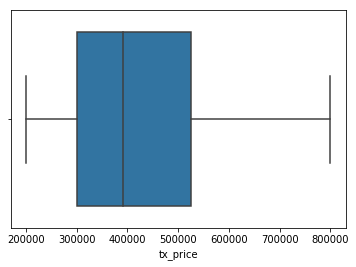

In [111]:
sns.boxplot(df.tx_price)

**Interpretation**

* The two vertical bars on the ends are the min and max values. All properties sold for between \$200,000 and \$800,000.
* The box in the middle is the interquartile range (25th percentile to 75th percentile).
* Half of all observations fall in that box.
* Finally, the vertical bar in the middle of the box is the median.

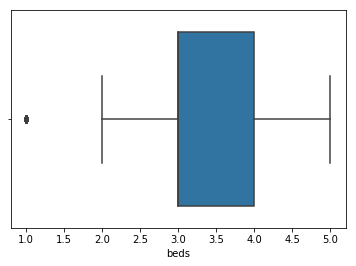

In [28]:
## Checking outliers in number of bedrooms
sns.boxplot(df.beds)

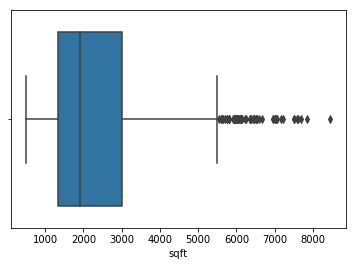

In [43]:
## Checking outliers in size of the house
sns.boxplot(df.sqft)

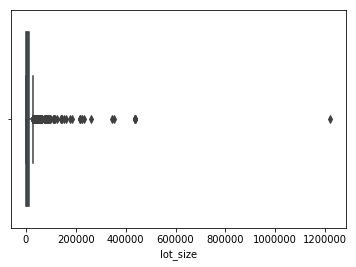

In [29]:
## Checking outliers in lot size
sns.boxplot(df.lot_size)

Look at the dot on the extreme right. This might indicate some erroneous point.

Let's look at the largest 5 lot sizes just to confirm.

In [112]:
df.lot_size.sort_values(ascending=False).head()

102     1220551
1111     436471
1876     436035
1832     436035
1115     435600
Name: lot_size, dtype: int64

The largest property has a lot_size of 1,220,551 sqft. The next largest has a lot_size of only 436,471 sqft.

Because it's unlikely the REIT will ever invest in properties with lots that large, and because it's the only one in the dataset, let's remove it so it doesn't interfere with our ability to model normal size properties.

In [113]:
## Remove observations with lot_size greater than 500,000 sqft.
df = df[df.lot_size <= 500000]
df.shape

(1882, 26)

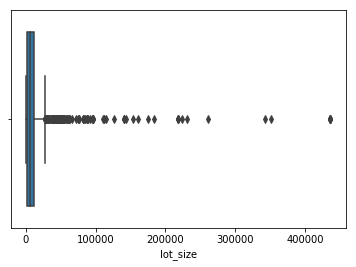

In [47]:
## Plotting the boxplot of lot size after the change
sns.boxplot(df.lot_size)

**Note:** Even though visually the plot looks the same but the x-axis dimensions have changed

##  Label missing categorical data
You cannot simply ignore missing values in your dataset. You must handle them in some way for the very practical reason that Scikit-Learn algorithms do not accept missing values.

In [32]:
# Display number of missing values by categorical feature
df.select_dtypes(include=['object']).isnull().sum()

property_type     0
exterior_walls    0
roof              0
dtype: int64

#### The best way to handle missing data for categorical features is to simply label them as 'Missing'

In [114]:
df['exterior_walls'] = df['exterior_walls'].fillna('Missing')
df['roof'] = df['roof'].fillna('Missing')
df.select_dtypes(include=['object']).isnull().sum()

property_type     0
exterior_walls    0
roof              0
dtype: int64

## 4.7 Flag and fill missing numeric data

In [115]:
# Display number of missing values by numeric feature
df.select_dtypes(exclude=['object']).isnull().sum()

tx_price              0
beds                  0
baths                 0
sqft                  0
year_built            0
lot_size              0
basement              0
restaurants           0
groceries             0
nightlife             0
cafes                 0
shopping              0
arts_entertainment    0
beauty_spas           0
active_life           0
median_age            0
married               0
college_grad          0
property_tax          0
insurance             0
median_school         0
num_schools           0
tx_year               0
dtype: int64

Well, it looks like we don't have any numerical features with missing values in this dataset.

### Before we move on to the next module, let's save the new dataframe we worked hard to clean.
This makes sure we don't have to re-do all the cleaning after clossing the session

In [118]:
# Save cleaned dataframe to new file
df.to_csv('Files/cleaned_df.csv', index=None)

#  Feature Engineering

##  Indicator variables

* For example, let's say you knew that homes with 2 bedrooms and 2 bathrooms are especially popular for investors.
* Maybe you suspect these types of properties command premium prices. (You don't need to know for sure.)
* Create an indicator variable to flag properties with 2 beds and 2 baths and name it 'two_and_two'.

In [119]:
df['two_and_two'] = ((df.beds == 2) & (df.baths == 2)).astype(int)

In [120]:
# Display percent of rows where two_and_two == 1
df[df['two_and_two']==1].shape[0]/df.shape[0]

0.09458023379383634

The interpretation is that almost 9.5% of the observations in our dataset were for properties with 2 beds and 2 baths.

People might also not take much interest in old properties.Lets figure it out.

In [121]:
df['old_properties'] = (df.year_built < 1980) .astype(int)

In [122]:
# Display percent of rows where old_properties == 1
df[df['old_properties']==1].shape[0]/df.shape[0]

0.3783209351753454

Create a new feature containing tax and insurance which a propery holder will have to pay monthly

In [123]:
df['tax_and_insurance'] = df.property_tax + df.insurance

The interpretation is that almost 9.5% of the observations in our dataset were for properties with 2 beds and 2 baths.

### Example: housing market recession
According to data from Zillow, the lowest housing prices were from 2010 to end of 2013 (country-wide).
![title](Images/zillow-housing-prices.png)

Create a new feature called 'during_recession' to indicate if a transaction falls between 2010 and 2013

In [124]:
df['during_recession'] = ((df.tx_year >= 2010) & (df.tx_year <= 2013)).astype(int)

In [125]:
# Print percent of transactions where during_recession == 1
df[df['during_recession']==1].shape[0]/df.shape[0]

0.2635494155154091

## Interaction features


In [126]:
# Create a property age feature
df['property_age'] = df.tx_year - df.year_built

**Note:** 'property_age' denotes the age of the property when it was sold and not how old it is today, since we want to predict the price at the time when the property is sold.

Sanity Check: It's always nice to do a quick sanity check after creating a feature, which could save you headaches down the road. For example, 'property_age' should never be less than 0, right?

In [127]:
print(df.property_age.min())

-8


Nice find. Something is definitely wrong. Age of property can never be negative.

In [128]:
# Number of observations with 'property_age' < 0
print(sum(df.property_age < 0))

19


* On second thought, it's possible that some home owners bought houses before the construction company built them.
* This is not uncommon, especially with single-family homes.
* However, for this problem, **we are only interested in houses that already exist** because the REIT only buys existing ones!

In [129]:
# Remove rows where property_age is less than 0
df = df[df.property_age >= 0]
df.shape

(1863, 31)

Now, let's add another interaction feature. How about the number of quality schools nearby?
* We know the number of schools nearby 
* We also have their median quality score
* Let's use this and create a new feature

In [130]:
# Create a school score feature that num_schools * median_school
df['school_score'] = df.num_schools * df.median_school

In [131]:
# Display median school score
df.school_score.median()

18.0

*  As we can see almost all properties have basement, this feature won't affect the price of the property much, so we can remove it 

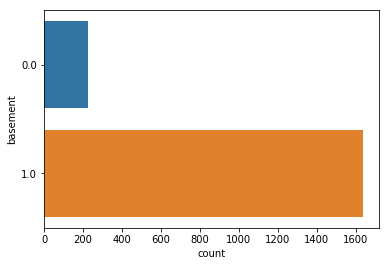

In [132]:
sns.countplot(y='basement', data=df)

In [133]:
#dropping the basement column
df = df.drop(['basement'], axis=1) 

* We can also delete some features which are less useful
* If we looked at the histogram of nightlife, almost all properties have nightlife within a mile also it has a poor relation with price of property(refer correlation part) so this feature might not be much useful do let's drop it.

In [134]:
df = df.drop(['nightlife'], axis=1) 

##  Handling Sparse Classes
The easiest way to check for sparse classes is simply by plotting the distributions of your categorical features. We already did this during exploratory analysis, but since we've done some data cleaning since then, let's plot them again.

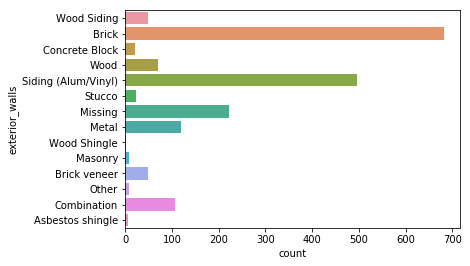

In [135]:
# Bar plot for exterior_walls
sns.countplot(y='exterior_walls', data=df)

Group 'Wood Siding', 'Wood Shingle', and 'Wood' together. Label all of them as 'Wood'.

In [136]:
df.exterior_walls.replace(['Wood Siding', 'Wood Shingle', 'Wood'], 'Wood', inplace=True)

Next, we can group the remaining sparse classes into a single 'Other' class, even though there's already an 'Other' class.<br>
Let's label 'Stucco', 'Other', 'Asbestos shingle', 'Concrete Block', and 'Masonry' as 'Other':

In [137]:
other_exterior_walls = ['Concrete Block', 'Stucco', 'Masonry', 'Other', 'Asbestos shingle']
df.exterior_walls.replace(other_exterior_walls, 'Other', inplace=True)

Finally, now that we've grouped together sparse classes, let's look at the bar plot for exterior walls again.

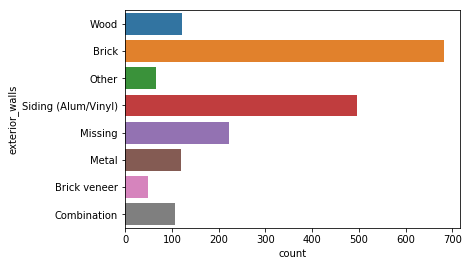

In [138]:
sns.countplot(y='exterior_walls', data=df)

Similarly we check for 'roof'

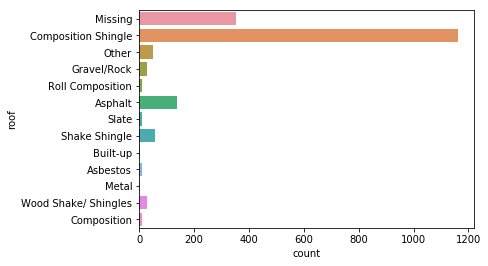

In [139]:
sns.countplot(y='roof', data=df)

Group 'Composition' and 'Wood Shake/ Shingles' into the 'Composition Shingle' class.

In [140]:
df.roof.replace(['Composition', 'Wood Shake/ Shingles'], 'Composition Shingle', inplace=True)

Next, let's group remaining sparse classes into a single 'Other' class.

Label 'Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Built-up', 'Asbestos', and 'Metal' as 'Other'.

In [141]:
other_roof = ['Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Built-up', 'Asbestos', 'Metal']
df.roof.replace(other_roof, 'Other', inplace=True)

Finally, display bar plot again.

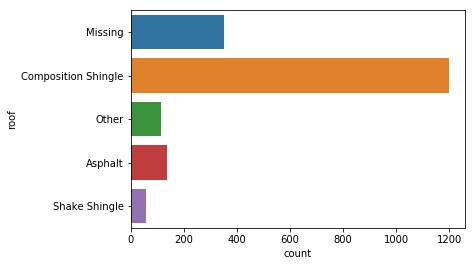

In [142]:
sns.countplot(y='roof', data=df)

**Now these plots look much nicer**

## Encode dummy variables (One Hot Encoding)
* Machine learning algorithms cannot directly handle categorical features. Specifically, they cannot handle text values.
* Therefore, we need to create dummy variables for our categorical features.
* *Dummy variables* are a set of binary (0 or 1) features that each represent a single class from a categorical feature.

In [143]:
# Create a new dataframe with dummy variables for for our categorical features.
df = pd.get_dummies(df, columns=['exterior_walls', 'roof', 'property_type'])

**Note:** There are many ways to perform one-hot encoding, you can also use LabelEncoder and OneHotEncoder classes in SKLEARN or use the above pandas function.

In [144]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,restaurants,groceries,cafes,shopping,...,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
0,295850,1,1,584,2013,0,107,9,19,89,...,0,0,1,0,0,1,0,0,1,0
1,216500,1,1,612,1965,0,105,15,13,87,...,0,0,0,0,1,0,0,0,1,0
2,279900,1,1,615,1963,0,183,13,30,101,...,0,0,1,0,0,1,0,0,1,0
3,379900,1,1,618,2000,33541,198,9,25,127,...,0,0,1,0,0,1,0,0,1,0
4,340000,1,1,634,1992,0,149,7,20,83,...,0,0,0,0,0,1,0,0,1,0


##  Remove unused or redundant features
* Redundant features would typically be those that have been **replaced by other features** that you've added.
* For example, since we used 'tx_year' and 'year_built' to create the 'property_age' feature, we might consider removing them.


In [145]:
# Drop 'tx_year' and 'year_built' from the dataset
df = df.drop(['tx_year', 'year_built'], axis=1)  ## axis=1 because we are dropping columns.

* Also remove 'property_tax' and 'insurance' as we have combined them in 'tax_and _insurance'

In [146]:
df = df.drop(['property_tax', 'insurance'], axis=1)  ## axis=1 because we are dropping columns.

Finally, before we move on to the next module, let's save our new DataFrame we that augmented through feature engineering. We'll call it the analytical base table because we'll be building our models on it.
* Remember to set the argument index=None to save only the data.

In [147]:
# Save analytical base table
df.to_csv('Files/analytical_base_table.csv', index=None)

# Machine Learning Models
## Data Preparation

In [8]:
df = pd.read_csv("Files/analytical_base_table.csv")

In [9]:
print(df.shape)

(1863, 38)


###  Train and Test Splits
Separate your dataframe into separate objects for the target variable (y) and the input features (X) and perform the train and test split

In [10]:
# Create separate object for target variable
y = df.tx_price
# Create separate object for input features
X = df.drop('tx_price', axis=1)

In [11]:
# Split X and y into train and test sets: 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

Let's confirm we have the right number of observations in each subset.

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1490, 37) (373, 37) (1490,) (373,)


### Data standardization
* In Data Standardization we perform zero mean centring and unit scaling; i.e. we make the mean of all the features as zero and the standard deviation as 1.
* Thus we use **mean** and **standard deviation** of each feature.
* It is very important to save the **mean** and **standard deviation** for each of the feature from the **training set**, because we use the same mean and standard deviation in the test set.

In [13]:
train_mean = X_train.mean()
train_std = X_train.std()

In [14]:
## Standardize the train data set
X_train = (X_train - train_mean) / train_std

In [15]:
## Check for mean and std dev.
X_train.describe()

,beds,baths,sqft,lot_size,restaurants,groceries,cafes,shopping,arts_entertainment,beauty_spas,...,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
count,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,...,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03,1.490000e+03
mean,-1.902281e-16,-4.254613e-17,7.663519e-17,3.911860e-17,1.409760e-16,1.621373e-16,8.946050e-18,2.315448e-17,-2.132895e-16,1.022299e-16,...,1.184362e-16,1.359092e-16,-2.747988e-16,-8.278240e-17,-2.752459e-16,2.772577e-16,-2.613867e-16,7.708226e-17,8.941393e-17,-8.941393e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.268801e+00,-1.697190e+00,-1.405276e+00,-3.662250e-01,-8.405927e-01,-9.756023e-01,-6.967768e-01,-7.559221e-01,-7.162235e-01,-8.905685e-01,...,-1.975485e-01,-6.055792e-01,-2.652453e-01,-2.808475e-01,-1.343434e+00,-4.829980e-01,-2.534612e-01,-1.862765e-01,-8.497402e-01,-1.176040e+00
25%,-4.047185e-01,-6.224713e-01,-7.491974e-01,-3.219217e-01,-7.128947e-01,-7.532980e-01,-6.967768e-01,-6.412758e-01,-7.162235e-01,-7.350745e-01,...,-1.975485e-01,-6.055792e-01,-2.652453e-01,-2.808475e-01,-1.343434e+00,-4.829980e-01,-2.534612e-01,-1.862765e-01,-8.497402e-01,-1.176040e+00
50%,5.273226e-01,4.522474e-01,-3.155383e-01,-1.885809e-01,-3.936498e-01,-3.086896e-01,-2.936977e-01,-3.737676e-01,-2.901213e-01,-3.074659e-01,...,-1.975485e-01,-6.055792e-01,-2.652453e-01,-2.808475e-01,7.438617e-01,-4.829980e-01,-2.534612e-01,-1.862765e-01,-8.497402e-01,8.497402e-01
75%,5.273226e-01,4.522474e-01,5.334699e-01,-2.831904e-02,3.512552e-01,5.805274e-01,1.093814e-01,1.994641e-01,3.490321e-01,4.700041e-01,...,-1.975485e-01,1.650203e+00,-2.652453e-01,-2.808475e-01,7.438617e-01,-4.829980e-01,-2.534612e-01,-1.862765e-01,1.176040e+00,8.497402e-01
max,1.459364e+00,3.676403e+00,4.255036e+00,1.217405e+01,4.820685e+00,4.359699e+00,5.618130e+00,5.740705e+00,6.740566e+00,5.990042e+00,...,5.058652e+00,1.650203e+00,3.767565e+00,3.558261e+00,7.438617e-01,2.069013e+00,3.942729e+00,5.364762e+00,1.176040e+00,8.497402e-01


In [16]:
## Note: We use train_mean and train_std_dev to standardize test data set
X_test = (X_test - train_mean) / train_std

In [17]:
## Check for mean and std dev. - not exactly 0 and 1
X_test.describe()

,beds,baths,sqft,lot_size,restaurants,groceries,cafes,shopping,arts_entertainment,beauty_spas,...,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,...,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,-0.117360,-0.080790,-0.090918,-0.032233,0.091066,0.141283,0.109381,0.132152,0.048019,0.107741,...,-0.042540,-0.025002,-0.005761,-0.002950,0.010790,-0.004068,0.027785,-0.052337,0.111555,-0.111555
std,0.958651,0.989343,1.001612,1.034313,1.003586,0.996496,1.077763,1.121003,1.013148,1.018536,...,0.890424,0.987522,0.990833,0.996149,0.997703,0.997762,1.050725,0.852944,1.012934,1.012934
min,-2.268801,-1.697190,-1.261108,-0.366225,-0.840593,-0.975602,-0.696777,-0.755922,-0.716224,-0.890568,...,-0.197548,-0.605579,-0.265245,-0.280848,-1.343434,-0.482998,-0.253461,-0.186276,-0.849740,-1.176040
25%,-0.404719,-0.622471,-0.803935,-0.324824,-0.627763,-0.753298,-0.562417,-0.564845,-0.716224,-0.657327,...,-0.197548,-0.605579,-0.265245,-0.280848,-1.343434,-0.482998,-0.253461,-0.186276,-0.849740,-1.176040
50%,-0.404719,-0.622471,-0.386851,-0.266126,-0.287235,-0.086385,-0.293698,-0.259121,-0.290121,-0.229719,...,-0.197548,-0.605579,-0.265245,-0.280848,0.743862,-0.482998,-0.253461,-0.186276,-0.849740,0.849740
75%,0.527323,0.452247,0.306233,-0.062883,0.500236,0.580527,0.243741,0.333218,0.349032,0.586625,...,-0.197548,1.650203,-0.265245,-0.280848,0.743862,-0.482998,-0.253461,-0.186276,1.176040,0.849740
max,1.459364,3.676403,4.127830,12.149022,4.820685,3.915091,5.349410,5.740705,6.740566,5.912295,...,5.058652,1.650203,3.767565,3.558261,0.743862,2.069013,3.942729,5.364762,1.176040,0.849740


##  Model 1 - Baseline Model
* In this model, for every test data point, we will simply predict the average of the train labels as the output.
* We will use this simple model to perform hypothesis testing for other complex models.

In [224]:
## Predict Train results
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [225]:
## Predict Test results
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [226]:
print("Train Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Baseline Model:
*******************************
Root mean squared error:  153791.70506675562
R-squared:  0.0
Mean Absolute Error:  127271.757171


In [227]:
print("Results for Baseline Model:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Results for Baseline Model:
*******************************
Root mean squared error:  143268.37228905046
R-squared:  -0.00731881601388
Mean Absolute Error:  120855.475979


##  Model-2 Ridge Regression

In [228]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Ridge(), tuned_params, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [229]:
model.best_estimator_

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [230]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [231]:
## Predict Test results
y_pred = model.predict(X_test)

In [232]:
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  118371.12102111954
R-squared:  0.407585476155
Mean Absolute Error:  92411.4441544


In [233]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  109556.25037528694
R-squared:  0.410965662533
Mean Absolute Error:  85353.5798568


### Feature Importance

In [234]:
## Building the model again with the best hyperparameters
model = Ridge(alpha=100)
model.fit(X_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [235]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
tax_and_insurance
sqft
college_grad
old_properties
property_age
baths
beds
cafes
beauty_spas
during_recession
lot_size
restaurants
groceries
shopping
exterior_walls_Missing
exterior_walls_Wood
property_type_Apartment / Condo / Townhouse
property_type_Single-Family
active_life
exterior_walls_Brick veneer
exterior_walls_Brick
exterior_walls_Combination
school_score
two_and_two
num_schools
exterior_walls_Siding (Alum/Vinyl)
roof_Asphalt
roof_Composition Shingle
exterior_walls_Metal
arts_entertainment
married
roof_Missing
median_age
roof_Shake Shingle
exterior_walls_Other
roof_Other
median_school


##  Model-3 Support Vector Regression
With an RBF Kernel

In [35]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(SVR(), tuned_params, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)
## This takes around 20 minutes

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [36]:
model.best_estimator_

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
## Building the model again with the best hyperparameters
model = SVR(C=100000, gamma=0.01)
model.fit(X_train, y_train)

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [39]:
## Predict Test results
y_pred = model.predict(X_test)

In [43]:
print("Train Results for Support Vector Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Support Vector Regression:
*******************************
Root mean squared error:  105184.79924921208
R-squared:  0.532221624884
Mean Absolute Error:  76724.6639426


In [44]:
print("Test Results for Support Vector Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Support Vector Regression:
*******************************
Root mean squared error:  102704.2797531053
R-squared:  0.48234146921
Mean Absolute Error:  75297.1941401


#### Unfortunately getting feature importance from RBF SVM is non trivial

## Model-4 Random Forest Regression

In [238]:
## Reference for random search on random forest
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)
## This takes around 15 minutes

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [239]:
model.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [240]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [241]:
## Predict Test results
y_pred = model.predict(X_test)

In [244]:
print("Train Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Random Forest Regression:
*******************************
Root mean squared error:  61521.268551314184
R-squared:  0.839976140739
Mean Absolute Error:  45133.3009272


In [245]:
print("Test Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Random Forest Regression:
*******************************
Root mean squared error:  95478.51890112278
R-squared:  0.552618893124
Mean Absolute Error:  70392.5334953


### Feature Importance

In [30]:
## Building the model again with the best hyperparameters
model = RandomForestRegressor(n_estimators=200, min_samples_split=10, min_samples_leaf=2)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
tax_and_insurance
sqft
property_age
lot_size
college_grad
married
median_age
during_recession
active_life
beauty_spas
shopping
restaurants
median_school
school_score
baths
groceries
arts_entertainment
cafes
beds
exterior_walls_Siding (Alum/Vinyl)
old_properties
exterior_walls_Missing
exterior_walls_Metal
exterior_walls_Brick
roof_Missing
roof_Composition Shingle
roof_Asphalt
roof_Shake Shingle
exterior_walls_Combination
num_schools
exterior_walls_Brick veneer
roof_Other
exterior_walls_Wood
exterior_walls_Other
two_and_two
property_type_Apartment / Condo / Townhouse
property_type_Single-Family


## Model-5 XGBoost Regression

In [252]:
## Reference for random search on xgboost
## https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [253]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [254]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [255]:
## Predict Test results
y_pred = model.predict(X_test)

In [256]:
print("Train Results for XGBoost Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", rs(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for XGBoost Regression:
*******************************
Root mean squared error:  91087.74583454759
R-squared:  0.649204441979
Mean Absolute Error:  68878.7502517


In [257]:
print("Test Results for XGBoost Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for XGBoost Regression:
*******************************
Root mean squared error:  97799.52471685012
R-squared:  0.530603571097
Mean Absolute Error:  71684.1126843


### Feature Importance

In [32]:
## Building the model again with the best hyperparameters
model = XGBRegressor(max_depth=2,learning_rate=0.05,n_estimators=400, reg_lambda=0.001)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
## Function to include figsize parameter
## Reference: https://stackoverflow.com/questions/40081888/xgboost-plot-importance-figure-size
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

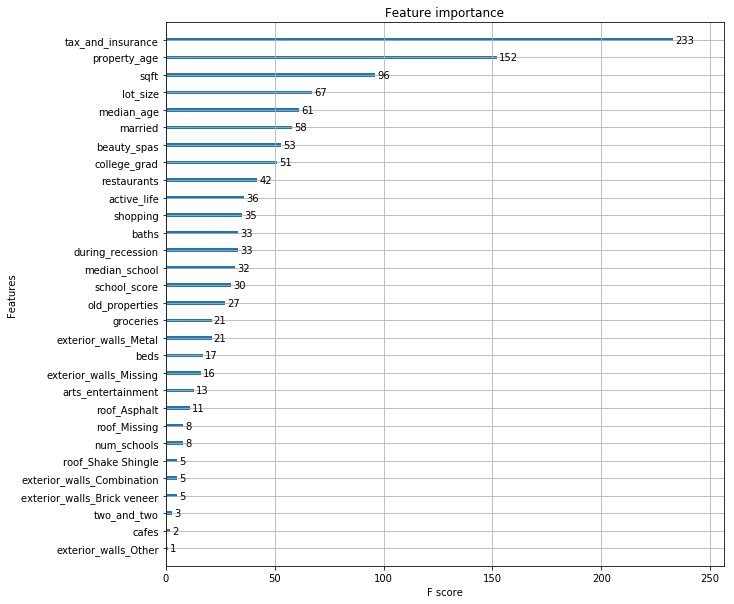

In [34]:
my_plot_importance(model, (10,10))

## Model-6 Lasso Regression

In [200]:
tuned_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
model = GridSearchCV(Lasso(), tuned_params, scoring = 'neg_mean_absolute_error', cv=20, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=20, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [201]:
model.best_estimator_

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [202]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [203]:
## Predict Test results
y_pred = model.predict(X_test)

In [206]:
print("Train Results for Lasso Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", rs(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Lasso Regression:
*******************************
Root mean squared error:  118409.68693205657
R-squared:  0.407199389965
Mean Absolute Error:  92369.8665302


In [207]:
print("Test Results for Lasso Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", rs(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Lasso Regression:
*******************************
Root mean squared error:  109600.67003738803
R-squared:  0.410487916893
Mean Absolute Error:  85287.8118162


### Feature Importance

In [208]:
## Building the model again with the best hyperparameters
model = Lasso(alpha=1000)
model.fit(X_train, y_train)

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [209]:
indices = np.argsort(-abs(model.coef_))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
tax_and_insurance
sqft
old_properties
college_grad
property_age
baths
beds
property_type_Apartment / Condo / Townhouse
cafes
exterior_walls_Brick
exterior_walls_Wood
during_recession
groceries
lot_size
exterior_walls_Brick veneer
shopping
restaurants
beauty_spas
active_life
school_score
num_schools
exterior_walls_Missing
two_and_two
exterior_walls_Combination
roof_Composition Shingle
roof_Asphalt
exterior_walls_Other
property_type_Single-Family
median_age
arts_entertainment
married
median_school
roof_Missing
roof_Other
roof_Shake Shingle
exterior_walls_Metal
exterior_walls_Siding (Alum/Vinyl)


## Model-7 Descision Tree Regression

In [210]:
tuned_params = {'min_samples_split': [2, 3, 4, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 6], 'max_depth': [2, 3, 4, 5, 6, 7]}
model = RandomizedSearchCV(DecisionTreeRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'min_samples_split': [2, 3, 4, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 6], 'max_depth': [2, 3, 4, 5, 6, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [211]:
model.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [212]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [213]:
## Predict Test results
y_pred = model.predict(X_test)

In [214]:
print("Train Results for Decision Tree Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", rs(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Decision Tree Regression:
*******************************
Root mean squared error:  106884.7383147663
R-squared:  0.516979489323
Mean Absolute Error:  81198.4313931


In [215]:
print("Test Results for Decision Tree Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", rs(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Decision Tree Regression:
*******************************
Root mean squared error:  102336.77202971975
R-squared:  0.486039526068
Mean Absolute Error:  76429.8248113


## Model-8 KN Regression

In [216]:
# creating odd list of K for KNN
neighbors = list(range(1,50,2))
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 9.


In [217]:
model = KNeighborsRegressor(n_neighbors = optimal_k)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform')

In [218]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [219]:
## Predict Test results
y_pred = model.predict(X_test)

In [220]:
print("Train Results for KN Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", rs(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for KN Regression:
*******************************
Root mean squared error:  115413.56596653137
R-squared:  0.436819128314
Mean Absolute Error:  89859.9055183


In [221]:
print("Test Results for KN Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", rs(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for KN Regression:
*******************************
Root mean squared error:  113442.20051898593
R-squared:  0.368438602203
Mean Absolute Error:  89734.2013703


## Compare all models

![title](Images/Result.png)



**From the above table, RMSE, R-squared, MAE for Rendom Forest Regressor is better(i.e RMSE and MAE is least and R-squared is more) than other models so Random Forest is the winning Model**

# Save the winning model to disk

In [18]:
win_model = RandomForestRegressor(n_estimators=200, min_samples_split=10, min_samples_leaf=2)
win_model.fit(X_train, y_train)
with open('rfr_real_estate.pkl', 'wb') as pickle_file:
       joblib.dump(win_model, 'rfr_real_estate.pkl') 